# Weighted Spin Model Analysis

## 1. Introduction
We study a **factorized spin model** with weighted interactions, where each spin \( s_i \) is associated with a coupling \( a_i \). The Hamiltonian for the system is:  

\[
H = - \sum_{i<j} a_i a_j \, \mathbf{s}_i \cdot \mathbf{s}_j
\]

- **Ising limit:** spins along z-axis, \( s_i \in \{-1, +1\} \)  
- **Heisenberg limit:** spins are 3D vectors on the unit sphere  
- **Weights \( a_i \):** sampled from Gaussian (SK-like) or heavy-tailed Pareto distributions  

---

## 2. Sampling Couplings \( a_i \)
Couplings can be drawn from Gaussian or Pareto distributions. The histogram shows their distribution.

---

## 3. Spin Initialization
- Parameter `alpha` controls spin type:  
  - `alpha = 0`: Ising spins  
  - `alpha = 1`: Heisenberg spins  

---

## 4. Dynamics: Glauber Updates
Single-spin updates according to the local field:

\[
\mathbf{h}_i = \sum_{j \in \text{neighbors}} a_i a_j \mathbf{s}_j
\]

Flip probability:  

\[
p_\text{flip} = \frac{1}{1 + \exp(\beta \Delta E)}
\]

---

## 5. Weighted Magnetization
Define the **weighted magnetization** along z-axis:

\[
M_z = \sum_i a_i s_i^z
\]

---

## 6. Time Series Simulation
Evolve the system for multiple sweeps to obtain:
- `M_series`: time series of weighted magnetization  
- `delta_M`: differences over interval `delta_t`  
- `kurt_M` / `kurt_delta`: kurtosis for M and ΔM  

---

## 7. Analytic Distributions
Factorized mean-field approximation with **self-consistent magnetization** can compute:
- P(M_z)  
- P(ΔM_z)  

Compare analytic distributions with simulation histograms.

---

## 8. Chaos Analysis
Use delay embedding to compute:
- Correlation dimension  
- Largest Lyapunov exponent  
- Surrogate tests to verify statistical significance  

---

## 9. Observations
- **Distributions:** P(M_z) and P(ΔM_z) depend on coupling weights and spin type  
- **Kurtosis:** indicates heavy tails for Pareto-distributed couplings  
- **Lyapunov exponent:** measures sensitivity to initial conditions  
- **Low-temperature limit:** may produce bimodal P(M_z) (quasi-stable states)


X^2 model for market return. Very similar to Curie-Weiss model for magnets, except the couplings are taken random. If the couplings are taken from uniform distribution we expect same physics as from Curie-Weiss model? How to interpret X in this model? Market mode?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Sample a_i ---
def sample_a_gauss(L, sigma=1.0, scale='sk'):
    N = L*L
    if scale == 'sk':    # SK-like scaling
        a = np.random.normal(0, sigma/np.sqrt(N), size=N)
        return a.reshape(L,L)
    else:
        a = np.random.normal(0, sigma, size=N)
        return a.reshape(L,L)

def sample_a_pareto(L, alp=1.6, xm=1.0, scale='levy'):
    N = L*L
    u = np.random.rand(N)
    mag = xm*(u**(-1/alp)-1)
    signs = np.random.choice([-1,1], size=N)
    a = signs*mag
    if scale=='levy':
        a = a * N**(-1/alp)
    return a.reshape(L,L)

# --- Initialize spins ---
def initialize_spins(L, alpha=1.0):
    if alpha==0:
        spins = np.zeros((L,L,3))
        spins[:,:,2] = np.random.choice([-1,1], size=(L,L))
    else:
        phi = np.random.uniform(0,2*np.pi, size=(L,L))
        costheta = np.random.uniform(-1,1, size=(L,L))
        theta = np.arccos(costheta)
        spins = np.zeros((L,L,3))
        spins[:,:,0] = np.sin(theta)*np.cos(phi)
        spins[:,:,1] = np.sin(theta)*np.sin(phi)
        spins[:,:,2] = np.cos(theta)
        if alpha < 1:
            spins[:,:,0] *= alpha
            spins[:,:,1] *= alpha
            spins[:,:,2] = np.sign(spins[:,:,2])*np.sqrt(
                1 - alpha**2*(spins[:,:,0]**2 + spins[:,:,1]**2)
            )
    return spins

# --- Local field ---
def local_field(spins, a, i, j):
    L = spins.shape[0]
    neighbors = [((i,(j+1)%L)), ((i,(j-1)%L)), (((i+1)%L,j)), (((i-1)%L,j))]
    h = np.zeros(3)
    for ni,nj in neighbors:
        h += a[i,j]*a[ni,nj]*spins[ni,nj]
    return h

# --- One Glauber sweep ---
def glauber_sweep(spins, a, beta, alpha=1.0):
    L = spins.shape[0]
    for _ in range(L*L):
        i,j = np.random.randint(L), np.random.randint(L)
        s_old = spins[i,j].copy()
        h = local_field(spins, a, i, j)

        # Propose new spin
        if alpha==0:
            s_new = np.array([0,0,np.random.choice([-1,1])])
        else:
            phi = np.random.uniform(0,2*np.pi)
            costheta = np.random.uniform(-1,1)
            theta = np.arccos(costheta)
            s_new = np.array([np.sin(theta)*np.cos(phi),
                              np.sin(theta)*np.sin(phi),
                              np.cos(theta)])
            if alpha < 1:
                s_new[0] *= alpha
                s_new[1] *= alpha
                s_new[2] = np.sign(s_new[2])*np.sqrt(
                    1 - alpha**2*(s_new[0]**2 + s_new[1]**2)
                )

        dE = -np.dot(s_new - s_old, h)
        p_flip = 1.0/(1.0+np.exp(beta*dE))
        if np.random.rand() < p_flip:
            spins[i,j] = s_new
    return spins

# --- Weighted M_z ---
def compute_weighted_Mz(spins, a):
    return np.sum(a * spins[:,:,2])

# --- Kurtosis ---
def compute_kurtosis(x):
    x = np.array(x)
    mean = np.mean(x)
    std = np.std(x)
    return np.mean((x-mean)**4)/(std**4)  # raw kurtosis

def run_factorized_model(L=32, beta=0.5, alpha=1.0, sweeps=2000, a=np.empty(32), delta_t=1):
    """
    Runs the factorized spin model and computes:
      - M_series: weighted magnetization time series
      - delta_M: differences over interval delta_t
    """
    spins = initialize_spins(L, alpha)
    N = L*L

    M_series = []
    for t in range(sweeps):
        spins = glauber_sweep(spins, a, beta, alpha)
        M_series.append(compute_weighted_Mz(spins, a))

    M_series = np.array(M_series)

    # Compute ΔM over arbitrary delta_t
    if delta_t < 1:
        raise ValueError("delta_t must be >= 1")
    delta_M = M_series[delta_t:] - M_series[:-delta_t]

    # Compute kurtosis
    kurt_M = compute_kurtosis(M_series)
    kurt_delta = compute_kurtosis(delta_M)

    return M_series, delta_M, a, kurt_M, kurt_delta


In [2]:

# ================================================================
#  SELF-CONSISTENT MEAN FIELD FOR FACTORIZED SPIN MODEL
# ================================================================
def compute_m_self_consistent(a, beta, tol=1e-8, max_iter=5000):
    """
    Solve self-consistency equation for m:
        m = (1/N) sum_i a_i * tanh(beta * a_i * m)
    Works for a 1D or 2D numpy array a.
    """
    a = np.ravel(a).astype(float)
    N = len(a)
    m = 0.0
    for it in range(max_iter):
        m_new = np.mean(a * np.tanh(beta * a * m))
        if abs(m_new - m) < tol:
            return m_new
        m = 0.9 * m + 0.1 * m_new  # under-relaxation
    return m

# ================================================================
#  FOURIER GRID HELPER
# ================================================================
def _prepare_fft_grid(a, num_k, scale_factor=1.0):
    """
    Prepares Fourier grids for inverse transform.
    Ensures the x range covers ±scale_factor * sum|a|.
    """
    a = np.ravel(a)
    sum_abs_a = np.sum(np.abs(a))
    if sum_abs_a == 0:
        sum_abs_a = 1.0
    margin = 1.2
    dk = np.pi / (margin * scale_factor * sum_abs_a)
    assert num_k % 2 == 0, "num_k must be even"
    k = dk * (np.arange(-num_k//2, num_k//2))
    dx = 2 * np.pi / (num_k * dk)
    x = np.linspace(-num_k*dx/2, num_k*dx/2 - dx, num_k)
    return k, dk, x, dx

# ================================================================
#  EXACT P(X)
# ================================================================
def exact_P_X(a, beta=0.5, num_k=2**14):
    """
    Exact probability distribution for X = sum a_i s_i,
    with independent spins having mean <s_i> = tanh(beta * a_i * m).
    """
    a = np.ravel(a).astype(float)
    m_sc = compute_m_self_consistent(a, beta)
    m_i = np.tanh(beta * a * m_sc)

    k, dk, x, dx = _prepare_fft_grid(a, num_k)
    phi_k = np.ones_like(k, dtype=complex)
    for ai, mi in zip(a, m_i):
        phi_k *= np.cos(k*ai) + 1j * mi * np.sin(k*ai)

    phi_shifted = np.fft.ifftshift(phi_k)
    f = np.fft.ifft(phi_shifted)
    P_x = (dk / (2*np.pi)) * np.fft.fftshift(f)
    P_x = np.real(P_x)
    P_x[P_x < 0] = 0
    P_x /= np.trapz(P_x, x)
    return x, P_x, m_sc

# ================================================================
#  EXACT P(ΔX)
# ================================================================
def exact_P_deltaX(a, beta=0.5, num_k=2**14):
    """
    Corrected probability distribution for ΔX = X(t+1) - X(t)
    using self-consistent mean-field m, assuming independent spins at successive times.
    """
    a = np.ravel(a).astype(float)
    m_sc = compute_m_self_consistent(a, beta)
    m_i = np.tanh(beta * a * m_sc)

    # Prepare Fourier grid (support roughly ±2 sum|a_i|)
    k, dk, delta_x, dx = _prepare_fft_grid(2*np.abs(a), num_k, scale_factor=2.0)

    # Characteristic function of X
    phi_X = np.ones_like(k, dtype=complex)
    for ai, mi in zip(a, m_i):
        phi_X *= np.cos(k*ai) + 1j*mi*np.sin(k*ai)

    # Characteristic function of ΔX
    phi_delta = np.abs(phi_X)**2

    # Inverse FFT to get P(ΔX)
    phi_shifted = np.fft.ifftshift(phi_delta)
    f = np.fft.ifft(phi_shifted)
    P_delta = np.real(np.fft.fftshift(f)) * dk / (2*np.pi)

    # Remove small negative numerical artifacts and normalize
    P_delta = np.maximum(P_delta, 0.0)
    P_delta /= np.trapz(P_delta, delta_x)

    return delta_x, P_delta, m_sc

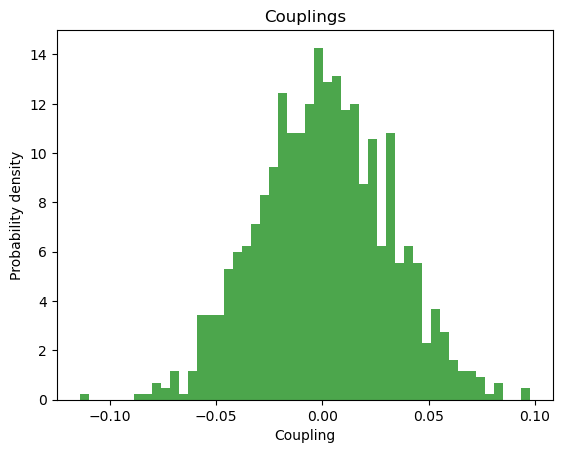

In [301]:
L = 32
beta = 10 #We probably need small beta for the analytic results to be valid (strong decorrelation)
alpha = 0 # Ising

a = sample_a_gauss(L, sigma=1.0, scale='sk')

plt.figure()
plt.hist(a.reshape(L*L) , bins=50, density=True, alpha=0.7, color='green')
plt.xlabel('Coupling')
plt.ylabel('Probability density')
plt.title('Couplings')
plt.show()

self-consistent m: 0.0


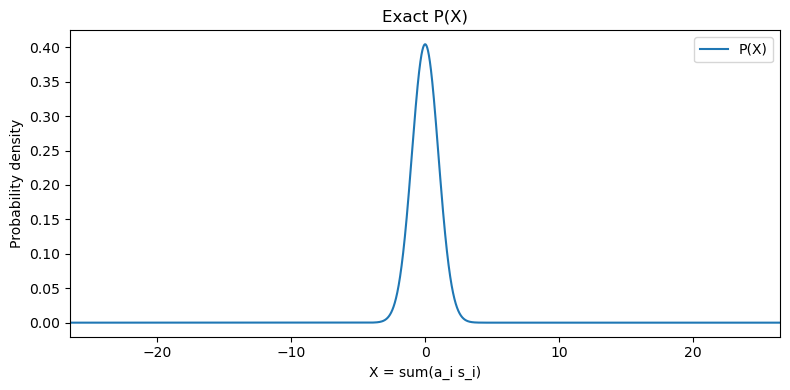

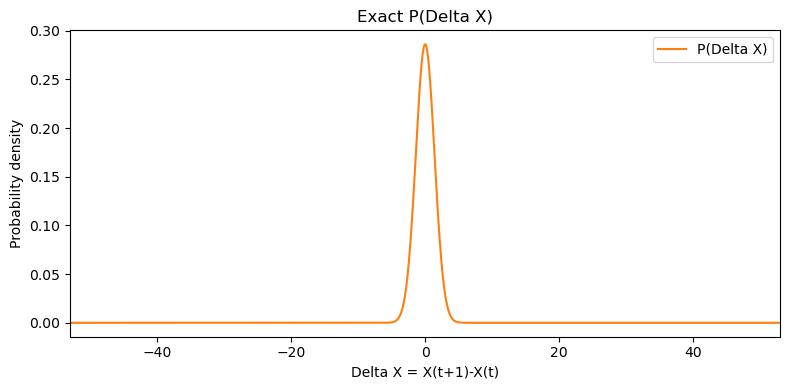

In [302]:
# -------------------------
# Example usage + plotting
# -------------------------
if __name__ == "__main__":
    num_k = 2**13   # reduce if memory / speed issues; increase for higher resolution

    # P(X)
    x, P_x, m_sc_x = exact_P_X(a, beta=beta, num_k=num_k)
    plt.figure(figsize=(8,4))
    plt.plot(x, P_x, label='P(X)')
    plt.xlabel('X = sum(a_i s_i)')
    plt.ylabel('Probability density')
    plt.title('Exact P(X)')
    plt.xlim(-np.sum(np.abs(a))*1.05, np.sum(np.abs(a))*1.05)
    plt.legend()
    plt.tight_layout()

    # P(Delta X)
    dx, P_dx, m_sc_dx = exact_P_deltaX(a, beta=beta, num_k=num_k)
    plt.figure(figsize=(8,4))
    plt.plot(dx, P_dx, label='P(Delta X)', color='C1')
    plt.xlabel('Delta X = X(t+1)-X(t)')
    plt.ylabel('Probability density')
    plt.title('Exact P(Delta X)')
    plt.xlim(-2*np.sum(np.abs(a))*1.05, 2*np.sum(np.abs(a))*1.05)
    plt.legend()
    plt.tight_layout()
    plt.show()



Kurtosis of M_z(t): 3.2137593861052425
Kurtosis of ΔM_z(t): 3.1047233654182596


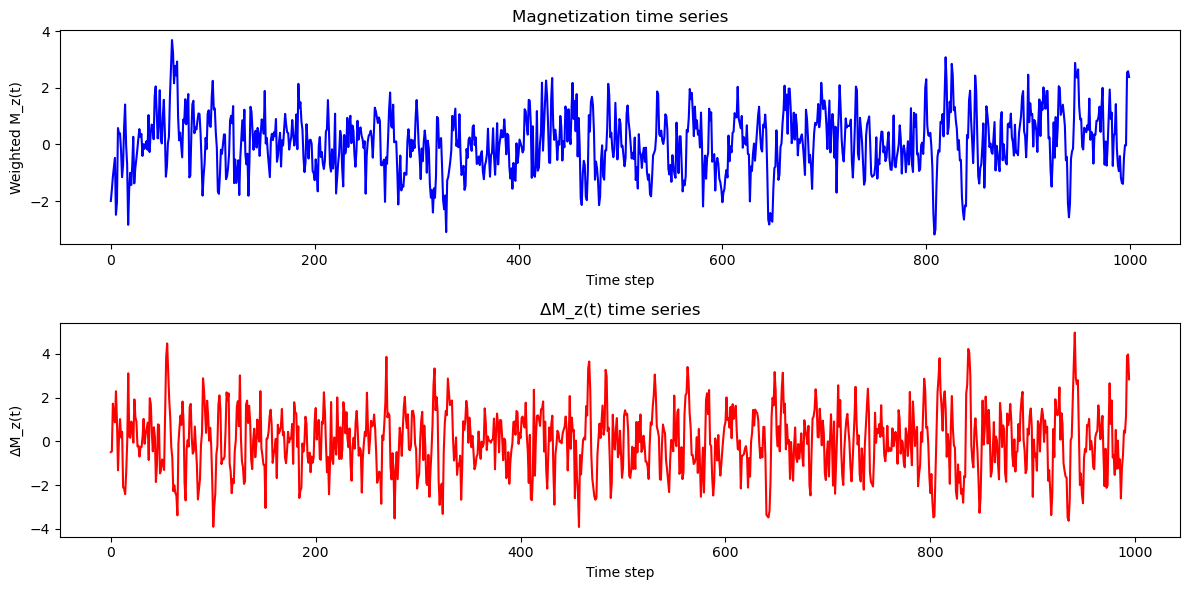

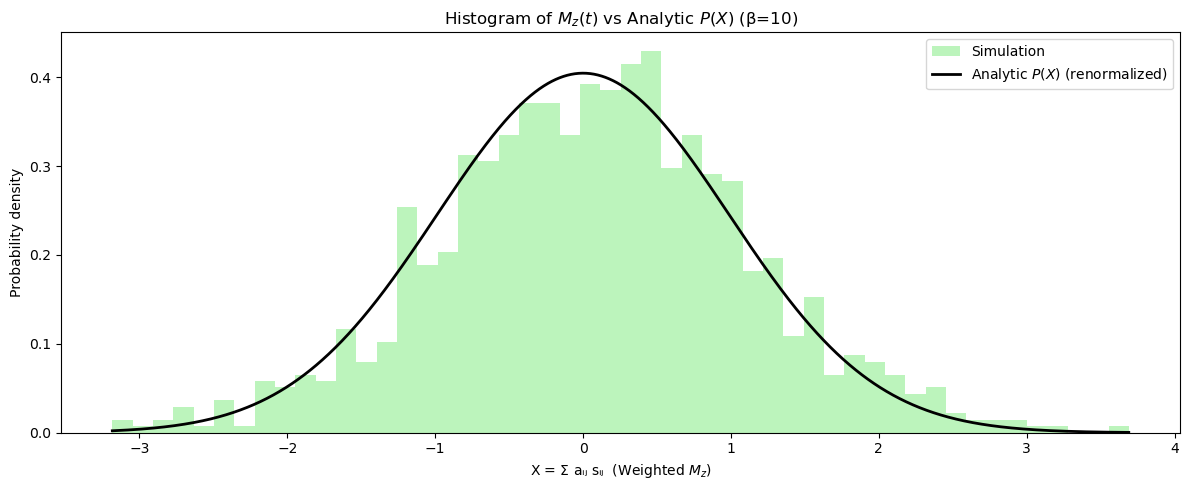

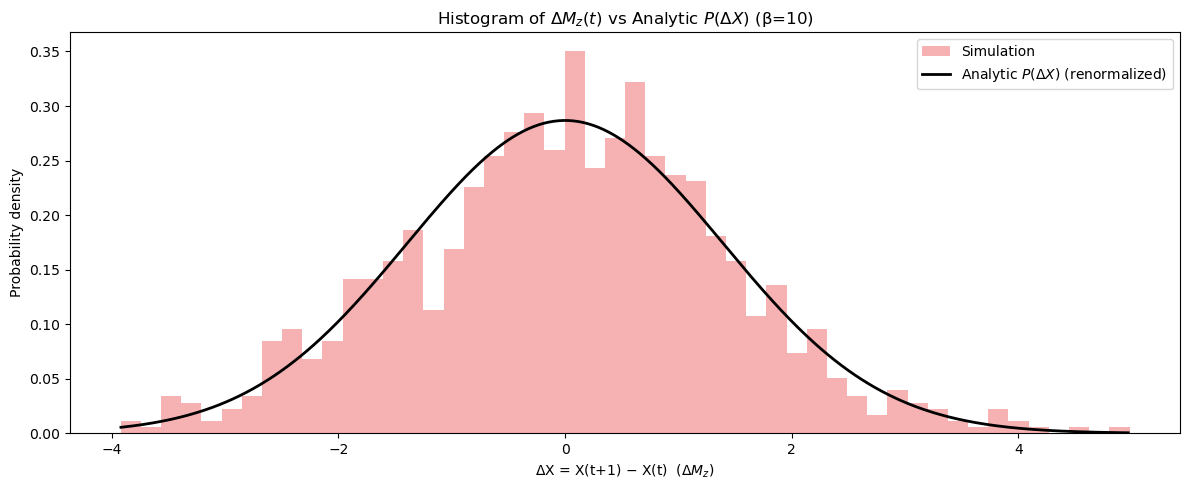

In [303]:
sweeps = 1000
deltat = 5 # #We probably need deltat =! 1 for the analytic results to be valid
#(we need the points in the time series to be decorrelated)

M, delta_M, a, kurt_M, kurt_delta = run_factorized_model(
    L=L,
    beta=beta,
    alpha=alpha,
    sweeps=sweeps,
    a=a,
    delta_t = deltat
)

print("Kurtosis of M_z(t):", kurt_M)
print("Kurtosis of ΔM_z(t):", kurt_delta)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(M, color='blue')
plt.xlabel('Time step')
plt.ylabel('Weighted M_z(t)')
plt.title('Magnetization time series')

plt.subplot(2,1,2)
plt.plot(delta_M, color='red')
plt.xlabel('Time step')
plt.ylabel('ΔM_z(t)')
plt.title('ΔM_z(t) time series')
plt.tight_layout()
plt.show()

from scipy.interpolate import interp1d

# Compute analytic distributions (exact)
x_analytic, P_x_analytic, m_sc = exact_P_X(a, beta=beta)
dx_analytic, P_dx_analytic, _ = exact_P_deltaX(a, beta=beta)

# --- P(X) histogram vs analytic ---
plt.figure(figsize=(12,5))
counts, bins, _ = plt.hist(M, bins=50, density=True, alpha=0.6, color='lightgreen', label='Simulation')
x_min, x_max = bins[0], bins[-1]

# restrict analytic curve to histogram range
mask_x = (x_analytic >= x_min) & (x_analytic <= x_max)
x_plot = x_analytic[mask_x]
P_plot = P_x_analytic[mask_x]

# renormalize within the interval
norm_factor = np.trapz(P_plot, x_plot)
P_plot /= norm_factor

plt.plot(x_plot, P_plot, 'k-', lw=2, label='Analytic $P(X)$ (renormalized)')
plt.xlabel("X = Σ aᵢⱼ sᵢⱼ  (Weighted $M_z$)")
plt.ylabel("Probability density")
plt.title(f"Histogram of $M_z(t)$ vs Analytic $P(X)$ (β={beta})")
plt.legend()
plt.tight_layout()
plt.show()

# --- P(ΔX) histogram vs analytic ---
plt.figure(figsize=(12,5))
counts_dx, bins_dx, _ = plt.hist(delta_M, bins=50, density=True, alpha=0.6, color='lightcoral', label='Simulation')
dx_min, dx_max = bins_dx[0], bins_dx[-1]

# restrict analytic ΔX curve to histogram range
mask_dx = (dx_analytic >= dx_min) & (dx_analytic <= dx_max)
dx_plot = dx_analytic[mask_dx]
P_dx_plot = P_dx_analytic[mask_dx]

# renormalize within the interval
norm_dx = np.trapz(P_dx_plot, dx_plot)
P_dx_plot /= norm_dx

plt.plot(dx_plot, P_dx_plot, 'k-', lw=2, label='Analytic $P(ΔX)$ (renormalized)')
plt.xlabel("ΔX = X(t+1) − X(t)  (Δ$M_z$)")
plt.ylabel("Probability density")
plt.title(f"Histogram of Δ$M_z(t)$ vs Analytic $P(ΔX)$ (β={beta})")
plt.legend()
plt.tight_layout()
plt.show()

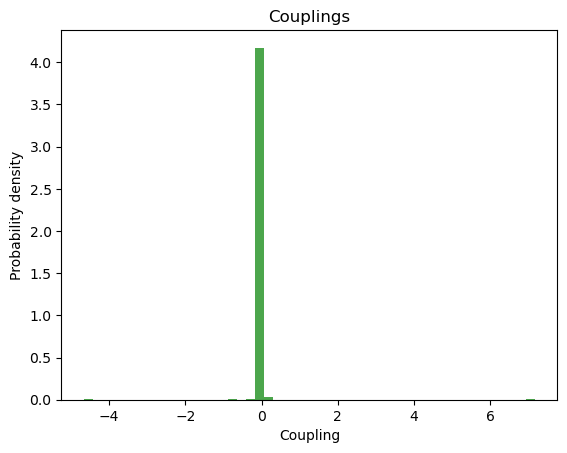

In [11]:
L = 32
alpha = 0 # Ising

a = sample_a_pareto(L, alp=1, xm=1.0, scale='levy')

plt.figure()
plt.hist(a.reshape(L*L) , bins=50, density=True, alpha=0.7, color='green')
plt.xlabel('Coupling')
plt.ylabel('Probability density')
plt.title('Couplings')
plt.show()


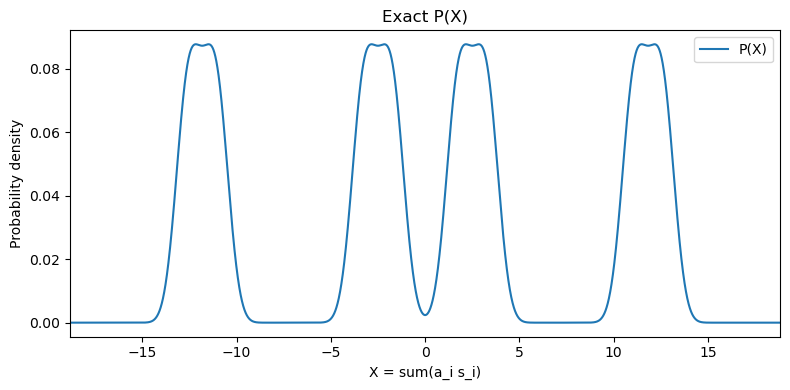

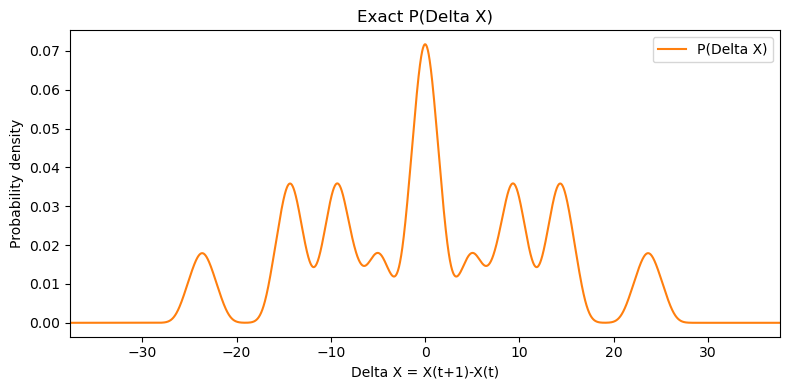

In [12]:
beta = 50 #We probably need small beta for the analytic results to be valid (strong decorrelation)
# -------------------------
# Example usage + plotting
# -------------------------
if __name__ == "__main__":
    num_k = 2**13   # reduce if memory / speed issues; increase for higher resolution

    # P(X)
    x, P_x, m_sc_x = exact_P_X(a, beta=beta, num_k=num_k)
    plt.figure(figsize=(8,4))
    plt.plot(x, P_x, label='P(X)')
    plt.xlabel('X = sum(a_i s_i)')
    plt.ylabel('Probability density')
    plt.title('Exact P(X)')
    plt.xlim(-np.sum(np.abs(a))*1.05, np.sum(np.abs(a))*1.05)
    plt.legend()
    plt.tight_layout()

    # P(Delta X)
    dx, P_dx, m_sc_dx = exact_P_deltaX(a, beta=beta, num_k=num_k)
    plt.figure(figsize=(8,4))
    plt.plot(dx, P_dx, label='P(Delta X)', color='C1')
    plt.xlabel('Delta X = X(t+1)-X(t)')
    plt.ylabel('Probability density')
    plt.title('Exact P(Delta X)')
    plt.xlim(-2*np.sum(np.abs(a))*1.05, 2*np.sum(np.abs(a))*1.05)
    plt.legend()
    plt.tight_layout()
    plt.show()



Kurtosis of M_z(t): 1.912700027490528
Kurtosis of ΔM_z(t): 9.4698227147101


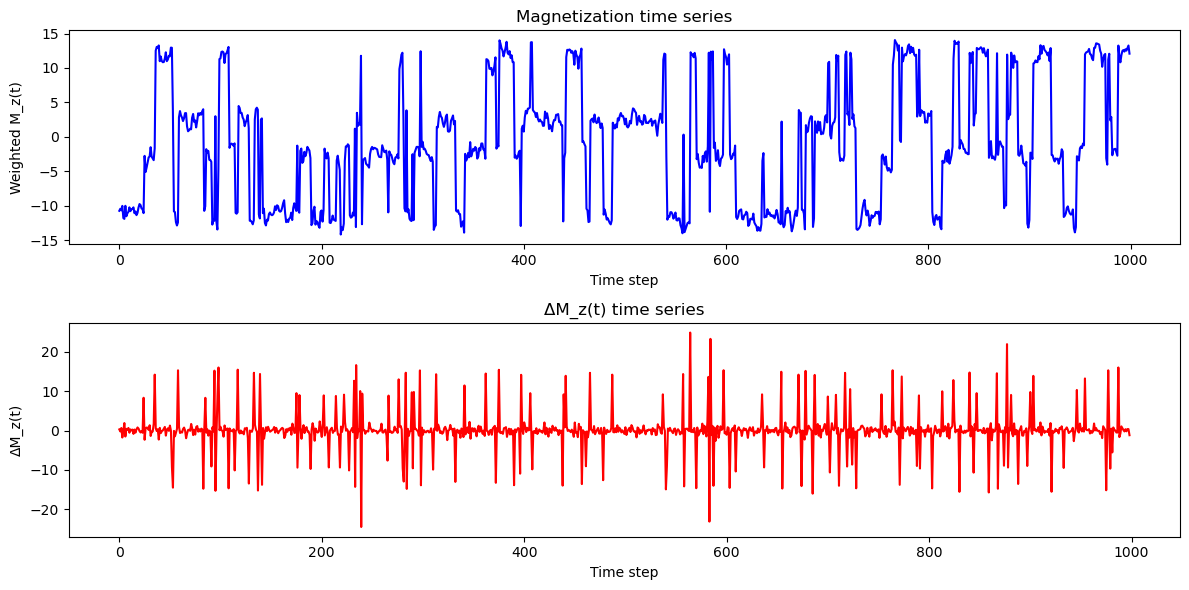

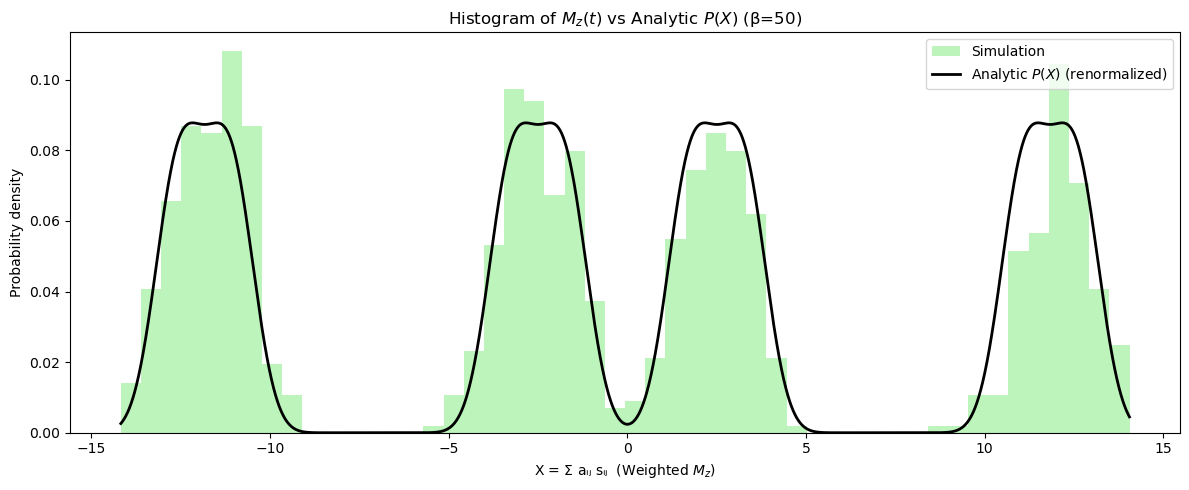

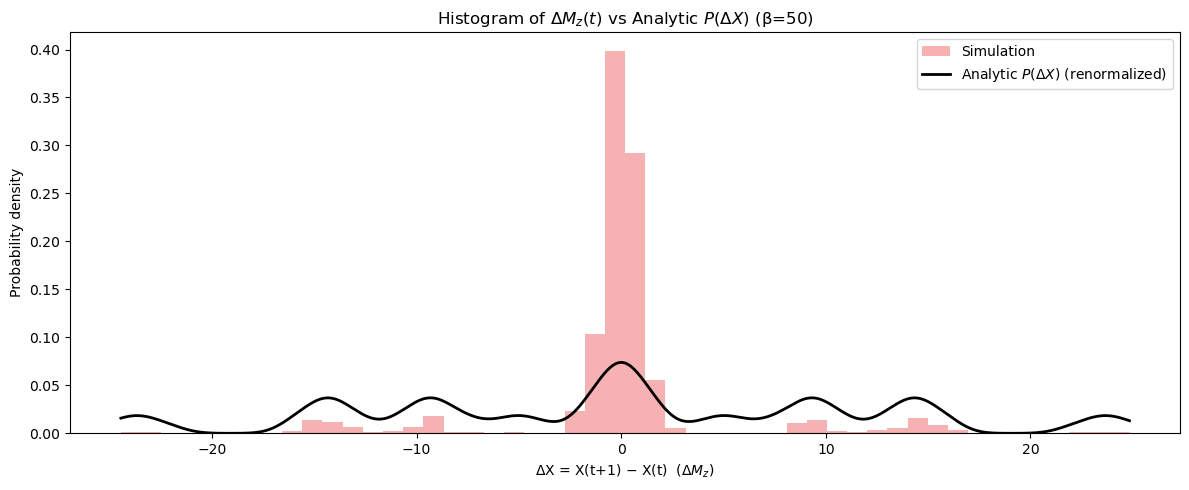

In [13]:
sweeps = 1000
deltat = 1 # #We probably need deltat =! 1 for the analytic results to be valid
#(we need the points in the time series to be decorrelated)

M, delta_M, a, kurt_M, kurt_delta = run_factorized_model(
    L=L,
    beta=beta,
    alpha=alpha,
    sweeps=sweeps,
    a=a,
    delta_t = deltat
)

print("Kurtosis of M_z(t):", kurt_M)
print("Kurtosis of ΔM_z(t):", kurt_delta)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(M, color='blue')
plt.xlabel('Time step')
plt.ylabel('Weighted M_z(t)')
plt.title('Magnetization time series')

plt.subplot(2,1,2)
plt.plot(delta_M, color='red')
plt.xlabel('Time step')
plt.ylabel('ΔM_z(t)')
plt.title('ΔM_z(t) time series')
plt.tight_layout()
plt.show()

from scipy.interpolate import interp1d

# Compute analytic distributions (exact)
x_analytic, P_x_analytic, m_sc = exact_P_X(a, beta=beta)
dx_analytic, P_dx_analytic, _ = exact_P_deltaX(a, beta=beta)

# --- P(X) histogram vs analytic ---
plt.figure(figsize=(12,5))
counts, bins, _ = plt.hist(M, bins=50, density=True, alpha=0.6, color='lightgreen', label='Simulation')
x_min, x_max = bins[0], bins[-1]

# restrict analytic curve to histogram range
mask_x = (x_analytic >= x_min) & (x_analytic <= x_max)
x_plot = x_analytic[mask_x]
P_plot = P_x_analytic[mask_x]

# renormalize within the interval
norm_factor = np.trapz(P_plot, x_plot)
P_plot /= norm_factor

plt.plot(x_plot, P_plot, 'k-', lw=2, label='Analytic $P(X)$ (renormalized)')
plt.xlabel("X = Σ aᵢⱼ sᵢⱼ  (Weighted $M_z$)")
plt.ylabel("Probability density")
plt.title(f"Histogram of $M_z(t)$ vs Analytic $P(X)$ (β={beta})")
plt.legend()
plt.tight_layout()
plt.show()

# --- P(ΔX) histogram vs analytic ---
plt.figure(figsize=(12,5))
counts_dx, bins_dx, _ = plt.hist(delta_M, bins=50, density=True, alpha=0.6, color='lightcoral', label='Simulation')
dx_min, dx_max = bins_dx[0], bins_dx[-1]

# restrict analytic ΔX curve to histogram range
mask_dx = (dx_analytic >= dx_min) & (dx_analytic <= dx_max)
dx_plot = dx_analytic[mask_dx]
P_dx_plot = P_dx_analytic[mask_dx]

# renormalize within the interval
norm_dx = np.trapz(P_dx_plot, dx_plot)
P_dx_plot /= norm_dx

plt.plot(dx_plot, P_dx_plot, 'k-', lw=2, label='Analytic $P(ΔX)$ (renormalized)')
plt.xlabel("ΔX = X(t+1) − X(t)  (Δ$M_z$)")
plt.ylabel("Probability density")
plt.title(f"Histogram of Δ$M_z(t)$ vs Analytic $P(ΔX)$ (β={beta})")
plt.legend()
plt.tight_layout()
plt.show()

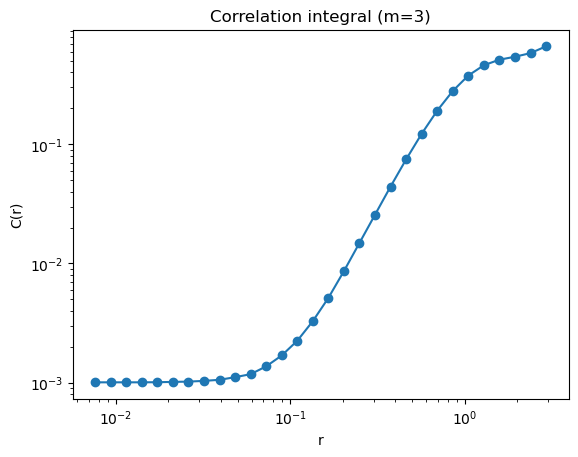

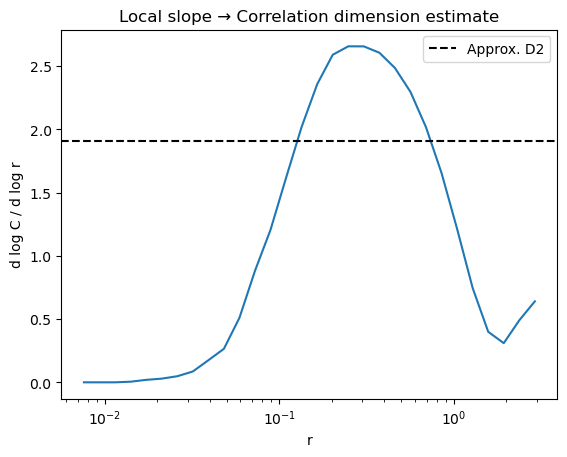

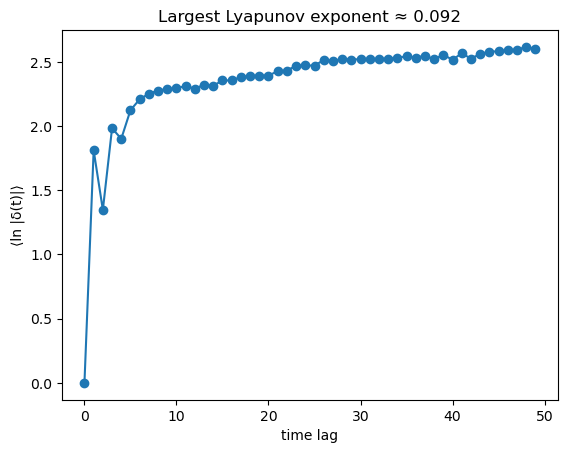

In [196]:
#Strange attractor or stochastic? 

import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# ==========================================================
# Helper: delay embedding
# ==========================================================
def delay_embedding(x, m, tau):
    """Construct delay-embedded vectors of dimension m and delay tau."""
    N = len(x) - (m - 1) * tau
    if N <= 0:
        raise ValueError("Time series too short for chosen m, tau")
    Y = np.zeros((N, m))
    for i in range(m):
        Y[:, i] = x[i * tau : i * tau + N]
    return Y

# ==========================================================
# Correlation dimension (Grassberger–Procaccia)
# ==========================================================
def correlation_dimension(x, m=3, tau=1, r_vals=None):
    Y = delay_embedding(x, m, tau)
    D = squareform(pdist(Y))
    N = len(D)
    if r_vals is None:
        r_vals = np.logspace(np.log10(np.min(D[D>0])/2), np.log10(np.max(D)/2), 30)
    C_r = []
    for r in r_vals:
        C = np.sum(D < r) / (N*N)
        C_r.append(C)
    C_r = np.array(C_r)
    # estimate slope over intermediate region
    log_r = np.log(r_vals)
    log_C = np.log(C_r)
    slope = np.gradient(log_C, log_r)
    return r_vals, C_r, slope

# ==========================================================
# Rosenstein method for largest Lyapunov exponent
# ==========================================================
def lyapunov_exponent(x, m=3, tau=1, max_t=50):
    """
    Estimate the largest Lyapunov exponent using the Rosenstein method.
    """
    Y = delay_embedding(x, m, tau)
    N = len(Y)
    D = squareform(pdist(Y))
    np.fill_diagonal(D, np.inf)
    
    nearest = np.argmin(D, axis=1)
    d0 = D[np.arange(N), nearest]
    
    Le = []
    for t in range(max_t):
        # valid indices that can be advanced by t steps
        valid = np.arange(N - t)
        # corresponding nearest neighbors also must not exceed N-t
        neigh = nearest[valid]
        mask = (neigh + t) < N
        valid = valid[mask]
        neigh = neigh[mask]
        
        if len(valid) == 0:
            break
        
        d = np.linalg.norm(Y[valid + t] - Y[neigh + t], axis=1)
        mask = d > 0
        if np.sum(mask) == 0:
            Le.append(np.nan)
        else:
            Le.append(np.mean(np.log(d[mask] / d0[valid][mask])))
    
    Le = np.array(Le)
    t_vals = np.arange(len(Le))
    
    # Fit a linear region (adjust as needed)
    lin_region = slice(1, min(10, len(Le)//2))
    coeffs = np.polyfit(t_vals[lin_region], Le[lin_region], 1)
    lambda1 = coeffs[0]
    
    return t_vals, Le, lambda1

def plot_attractor(x, m=3, tau=1, title="Reconstructed attractor"):
    Y = delay_embedding(x, m, tau)
    
    if m == 2:
        plt.figure(figsize=(6, 6))
        plt.plot(Y[:, 0], Y[:, 1], '.', ms=2, alpha=0.6)
        plt.xlabel(f"x(t)")
        plt.ylabel(f"x(t+{tau})")
        plt.title(title)
        plt.grid(True)
        plt.show()
        
    elif m == 3:
        fig = plt.figure(figsize=(7, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(Y[:, 0], Y[:, 1], Y[:, 2], lw=0.8, alpha=0.7)
        ax.set_xlabel(f"x(t)")
        ax.set_ylabel(f"x(t+{tau})")
        ax.set_zlabel(f"x(t+2τ)")
        ax.set_title(title)
        plt.show()
    else:
        raise ValueError("Only 2D or 3D embeddings are supported for visualization.")


# ==========================================================
# Example usage
# ==========================================================
# M_series = your magnetization time series from simulation
# For example:
# M_series, delta_M, a, kurt_M, kurt_delta = run_factorized_model(...)

# Normalize
x = (M - np.mean(M)) / np.std(M)

# Choose embedding params
m, tau = 3, 2

# Correlation dimension
r_vals, C_r, slope = correlation_dimension(x, m=m, tau=tau)
plt.loglog(r_vals, C_r, 'o-')
plt.xlabel("r")
plt.ylabel("C(r)")
plt.title("Correlation integral (m={})".format(m))
plt.show()

plt.semilogx(r_vals, slope)
plt.axhline(np.mean(slope[10:20]), color='k', linestyle='--', label="Approx. D2")
plt.legend()
plt.ylabel("d log C / d log r")
plt.xlabel("r")
plt.title("Local slope → Correlation dimension estimate")
plt.show()

# Lyapunov exponent
t_vals, Le, lambda1 = lyapunov_exponent(x, m=m, tau=tau)
plt.plot(t_vals, Le, 'o-')
plt.title(f"Largest Lyapunov exponent ≈ {lambda1:.3f}")
plt.xlabel("time lag")
plt.ylabel("⟨ln |δ(t)|⟩")
plt.show()


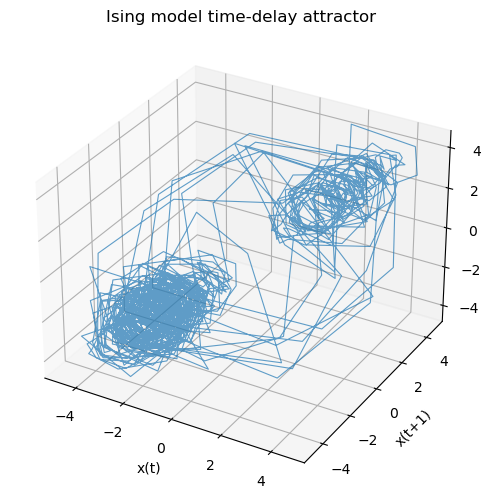

In [201]:
# assuming M_series is your magnetization time series
plot_attractor(M, m=3, tau=1, title="Ising model time-delay attractor")


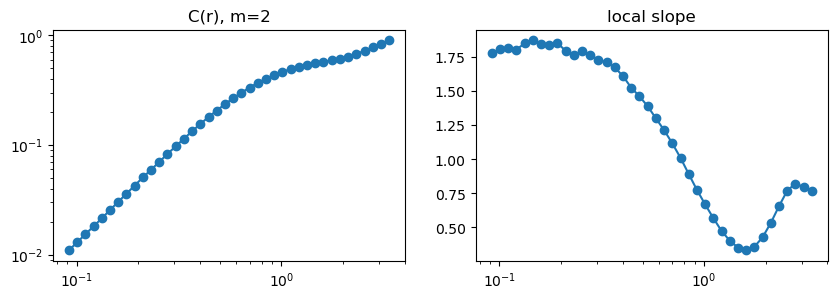

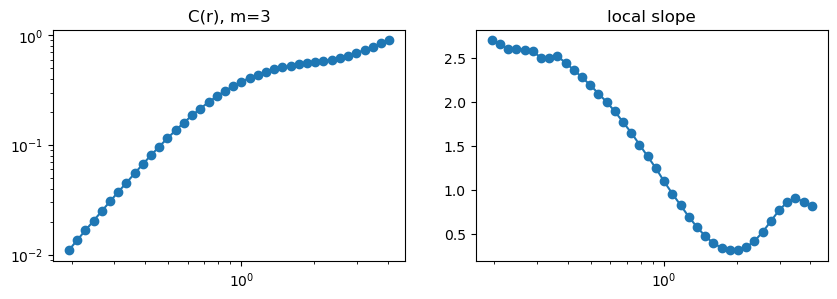

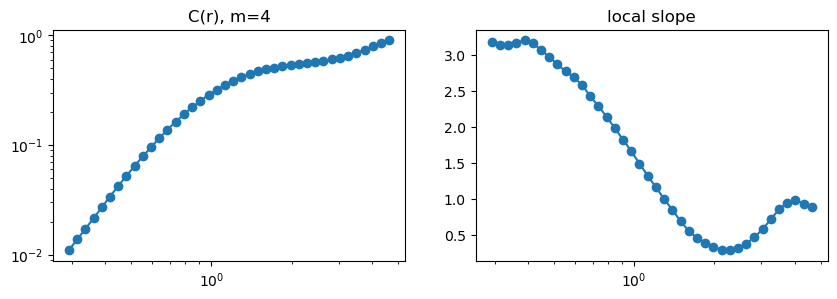

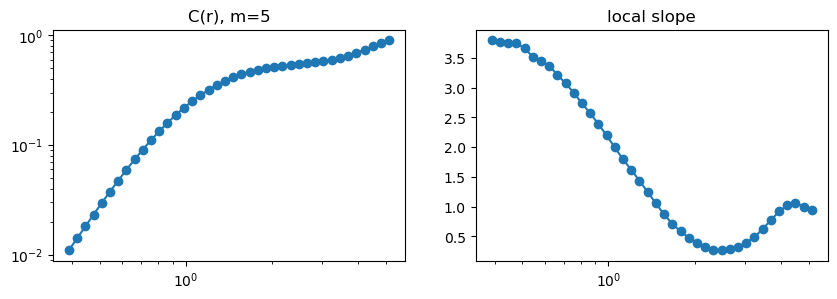

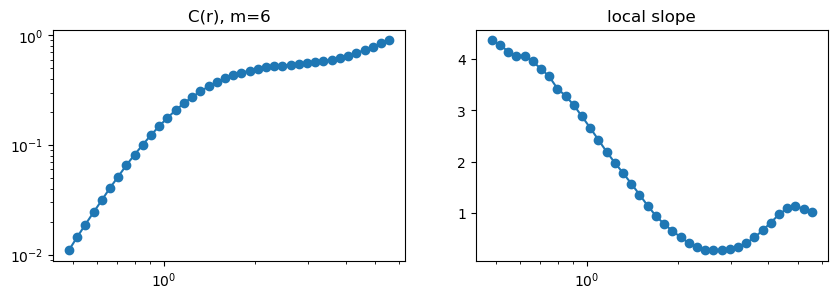

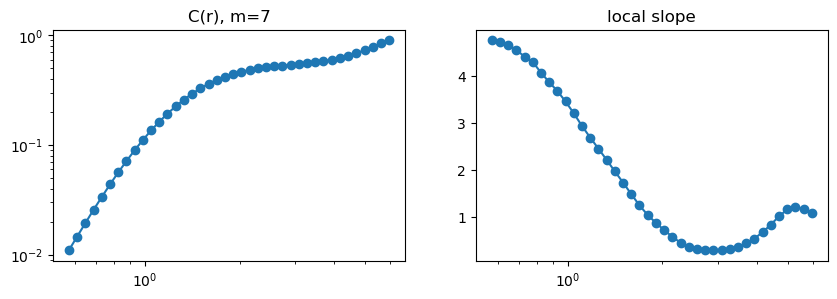

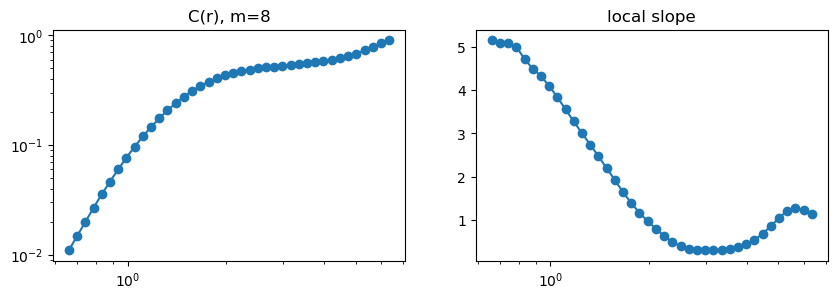

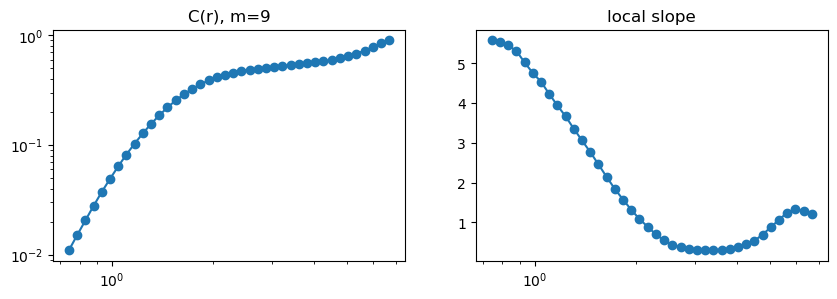

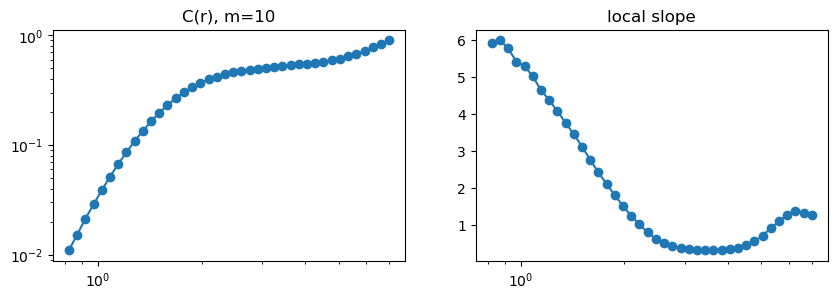

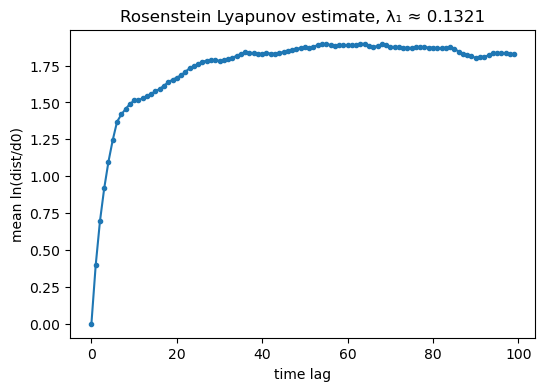

Largest Lyapunov exponent λ₁ ≈ 0.1321
Surrogate slopes mean,std: 0.1383 ± 0.0022
Analysis complete: Correlation dimension vs m, Lyapunov exponent, and surrogate check.


In [200]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import cKDTree

rng = np.random.default_rng()

# -----------------------------
# Delay embedding
# -----------------------------
def delay_embedding(x, m, tau):
    x = np.asarray(x)
    N = len(x) - (m-1)*tau
    if N <= 0:
        raise ValueError("Time series too short for chosen m and tau")
    return np.array([x[i: i+N] for i in range(0, m*tau, tau)]).T

# -----------------------------
# Correlation integral
# -----------------------------
def correlation_integral(Y, r_vals):
    D = squareform(pdist(Y))
    N = D.shape[0]
    C = np.array([np.sum(D<r)/(N*(N-1)) for r in r_vals])
    return C

def local_slope(r_vals, C):
    lr = np.log(r_vals)
    lC = np.log(np.clip(C, 1e-300, None))
    slope = np.gradient(lC, lr)
    return slope

# -----------------------------
# Rosenstein Lyapunov exponent
# -----------------------------
def lyapunov_rosenstein(x, m=3, tau=1, max_t=50):
    """
    Rosenstein estimate of the largest Lyapunov exponent.
    
    x : 1D time series
    m : embedding dimension
    tau : time delay
    max_t : maximum evolution time
    """
    x = np.asarray(x)
    N = len(x) - (m-1)*tau
    if N <= 0:
        raise ValueError("Time series too short for embedding")

    # --- Delay embedding ---
    Y = np.array([x[i:i + m*tau:tau] for i in range(N)])

    # --- Nearest neighbors (exclude temporal neighbors) ---
    tree = cKDTree(Y)
    dist, neigh = tree.query(Y, k=2)
    neigh = neigh[:,1]  # first neighbor excluding self

    # valid indices to avoid temporal neighbors
    valid = np.arange(N)
    
    # adjust max_t so we never exceed array bounds
    max_t = min(max_t, N - 1 - np.max(neigh))

    L = []
    tvals = np.arange(max_t)
    for t in tvals:
        d = np.linalg.norm(Y[valid[:N-t]] - Y[neigh[valid[:N-t]] + t], axis=1)
        mask = d > 0
        if np.sum(mask) == 0:
            L.append(np.nan)
            continue
        L.append(np.mean(np.log(d[mask])))

    return tvals, np.array(L)

# -----------------------------
# Phase-randomized surrogate
# -----------------------------
def phase_randomized_surrogate(x):
    n = len(x)
    Xf = np.fft.rfft(x)
    mag = np.abs(Xf)
    phase = np.angle(Xf)
    rnd_phase = np.zeros_like(phase)
    rnd_phase[1:-1] = rng.uniform(0, 2*np.pi, size=len(phase)-2)
    rnd_phase[0] = phase[0]; rnd_phase[-1] = phase[-1]
    xs = np.fft.irfft(mag*np.exp(1j*rnd_phase), n)
    return xs

# -----------------------------
# Analyze M(t) series
# -----------------------------
def analyze_M_series(M, tau=1, max_m=8):
    from scipy.spatial.distance import pdist, squareform
    import matplotlib.pyplot as plt
    import numpy as np

    M = (M - np.mean(M)) / (np.std(M) + 1e-12)

    # --- Correlation dimension ---
    for m in range(2, max_m + 1):
        try:
            Y = delay_embedding(M, m, tau)
        except:
            continue
        Dmat = squareform(pdist(Y))
        rmin = np.percentile(Dmat[Dmat > 0], 1)
        rmax = np.percentile(Dmat, 90)
        r_vals = np.logspace(np.log10(rmin), np.log10(rmax), 40)
        C = correlation_integral(Y, r_vals)
        slope = local_slope(r_vals, C)
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.loglog(r_vals, C, 'o-')
        plt.title(f"C(r), m={m}")
        plt.subplot(1, 2, 2)
        plt.semilogx(r_vals, slope, 'o-')
        plt.title("local slope")
        plt.show()

    # --- Lyapunov exponent using robust Rosenstein ---
    m_use = min(max_m, 6)
    tvals, Le, lambda1 = lyapunov_exponent(M, m=m_use, tau=tau, max_t=100)
    plt.figure(figsize=(6,4))
    plt.plot(tvals, Le, '.-')
    plt.xlabel("time lag")
    plt.ylabel("mean ln(dist/d0)")
    plt.title(f"Rosenstein Lyapunov estimate, λ₁ ≈ {lambda1:.4f}")
    plt.show()
    print(f"Largest Lyapunov exponent λ₁ ≈ {lambda1:.4f}")

    # --- Surrogates ---
    nsurr = 5
    slopes_surr = []
    for i in range(nsurr):
        M_surr = phase_randomized_surrogate(M)
        tvals_s, Le_s, lambda_s = lyapunov_exponent(M_surr, m=m_use, tau=tau, max_t=100)
        slopes_surr.append(lambda_s)
    print(f"Surrogate slopes mean,std: {np.mean(slopes_surr):.4f} ± {np.std(slopes_surr):.4f}")

    print("Analysis complete: Correlation dimension vs m, Lyapunov exponent, and surrogate check.")

    # M = your weighted magnetization time series
analyze_M_series(M, tau=1, max_m=10)


In [357]:
import numpy as np

# ================================================================
#  LANGEVIN FUNCTION
# ================================================================
def langevin(x):
    """L(x) = coth(x) - 1/x"""
    with np.errstate(divide='ignore', invalid='ignore'):
        L = 1/np.tanh(x) - 1/x
        mask = np.abs(x) < 1e-8
        L[mask] = x[mask]/3.0
    return L

# ================================================================
#  SELF-CONSISTENT MAGNETIZATION
# ================================================================
def compute_m_self_consistent(a, beta=0.5, tol=1e-8, max_iter=5000):
    """
    Self-consistent mean magnetization for Ising (alpha=0) or Heisenberg (alpha=1) spins.
    For Ising: m = mean(a_i * tanh(beta * a_i * m))
    For Heisenberg: m = mean(a_i * L(beta * a_i * m))
    """
    a = np.ravel(a).astype(float)
    m = 0.0
    for _ in range(max_iter):
        m_new = np.mean(a * langevin(beta * a * m))
        if np.abs(m_new - m) < tol:
            return m_new
        m = 0.9*m + 0.1*m_new  # under-relaxation
    return m

# ================================================================
#  CHARACTERISTIC FUNCTIONS
# ================================================================

def phi_i_heisenberg(k, ai, beta=0.0, mz=0.0):
    """Characteristic function for Heisenberg spin s_i^z ∈ [-1,1]"""
    x = beta * ai * mz
    k_ai = k * ai
    phi = np.zeros_like(k, dtype=complex)
    mask = np.abs(x) < 1e-12
    phi[mask] = np.sinc(k_ai[mask]/np.pi)
    mask = ~mask
    if np.any(mask):
        phi[mask] = (np.exp(x + 1j*k_ai[mask]) - np.exp(-x - 1j*k_ai[mask])) / (2*np.sinh(x))
    return phi

# ================================================================
#  FFT GRID
# ================================================================
def _prepare_fft_grid(a, num_k=2**14, scale_factor=1.0):
    a = np.ravel(a)
    sum_abs_a = np.sum(np.abs(a))
    if sum_abs_a == 0: sum_abs_a = 1.0
    margin = 1.2
    dk = np.pi / (margin * scale_factor * sum_abs_a)
    assert num_k % 2 == 0
    k = dk * np.arange(-num_k//2, num_k//2)
    dx = 2 * np.pi / (num_k * dk)
    x = np.linspace(-num_k*dx/2, num_k*dx/2 - dx, num_k)
    return k, dk, x, dx

# ================================================================
#  ANALYTIC P(X)
# ================================================================
def exact_P_X(a, beta=0.5, num_k=2**14):
    a = np.ravel(a)
    m = compute_m_self_consistent(a, beta=beta)
    k, dk, x, dx = _prepare_fft_grid(a, num_k)
    
    phi_k = np.ones_like(k, dtype=complex)
    for ai in a:
        phi_k *= phi_i_heisenberg(k, ai, beta, m)
    
    phi_shifted = np.fft.ifftshift(phi_k)
    f = np.fft.ifft(phi_shifted)
    P_x = (dk/(2*np.pi)) * np.fft.fftshift(f)
    P_x = np.real(P_x)
    P_x[P_x < 0] = 0.0
    P_x /= np.trapz(P_x, x)
    return x, P_x, m

# ================================================================
#  ANALYTIC P(ΔX)
# ================================================================
def exact_P_deltaX(a, beta=0.5, num_k=2**14):
    a = np.ravel(a)
    m = compute_m_self_consistent(a, beta=beta)
    k, dk, x, dx = _prepare_fft_grid(a, num_k, scale_factor=2.0)
    
    phi_k = np.ones_like(k, dtype=complex)
    for ai in a:
        phi_i = phi_i_heisenberg(k, ai, beta, m)
        phi_k *= np.abs(phi_i)**2  # convolution for ΔX
    
    phi_shifted = np.fft.ifftshift(phi_k)
    f = np.fft.ifft(phi_shifted)
    P_dx = (dk/(2*np.pi)) * np.fft.fftshift(f)
    P_dx = np.real(P_dx)
    P_dx[P_dx < 0] = 0.0
    P_dx /= np.trapz(P_dx, x)
    return x, P_dx, m


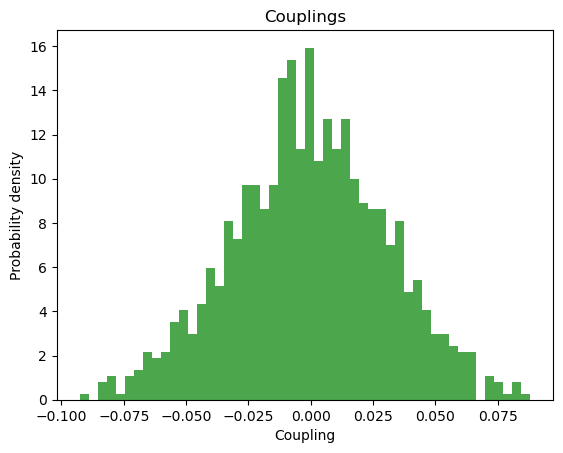

In [368]:
L = 32
beta = 10
alpha = 1 # Heisenberg

a = sample_a_gauss(L, sigma=1.0, scale='sk')

plt.figure()
plt.hist(a.reshape(L*L) , bins=50, density=True, alpha=0.7, color='green')
plt.xlabel('Coupling')
plt.ylabel('Probability density')
plt.title('Couplings')
plt.show()

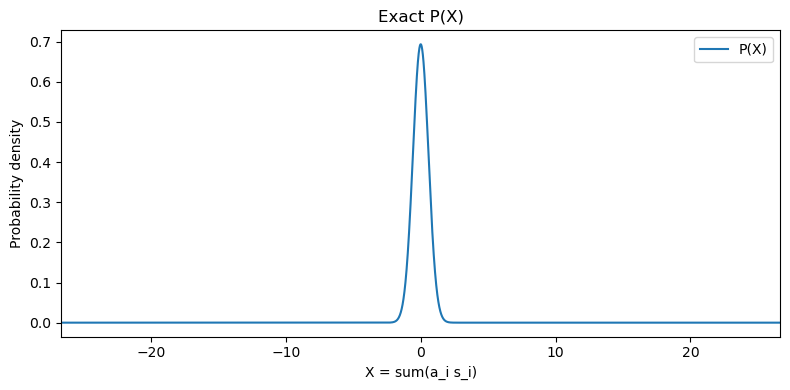

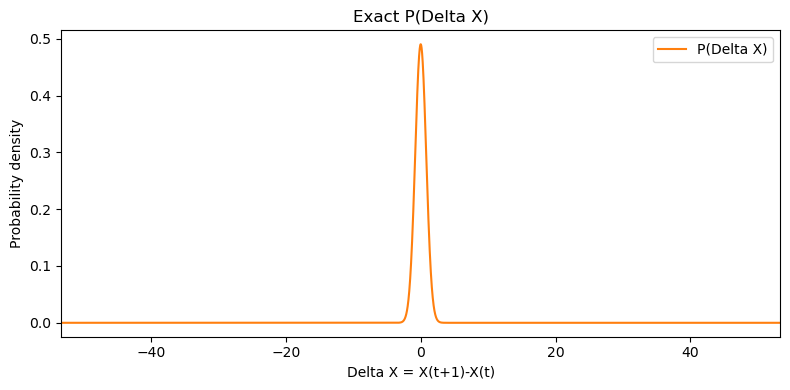

In [369]:
# -------------------------
# Example usage + plotting
# -------------------------
if __name__ == "__main__":
    num_k = 2**13   # reduce if memory / speed issues; increase for higher resolution

    # P(X)
    x, P_x, m_sc_x = exact_P_X(a, beta=beta, num_k=num_k)
    plt.figure(figsize=(8,4))
    plt.plot(x, P_x, label='P(X)')
    plt.xlabel('X = sum(a_i s_i)')
    plt.ylabel('Probability density')
    plt.title('Exact P(X)')
    plt.xlim(-np.sum(np.abs(a))*1.05, np.sum(np.abs(a))*1.05)
    plt.legend()
    plt.tight_layout()

    # P(Delta X)
    dx, P_dx, m_sc_dx = exact_P_deltaX(a, beta=beta, num_k=num_k)
    plt.figure(figsize=(8,4))
    plt.plot(dx, P_dx, label='P(Delta X)', color='C1')
    plt.xlabel('Delta X = X(t+1)-X(t)')
    plt.ylabel('Probability density')
    plt.title('Exact P(Delta X)')
    plt.xlim(-2*np.sum(np.abs(a))*1.05, 2*np.sum(np.abs(a))*1.05)
    plt.legend()
    plt.tight_layout()
    plt.show()



Kurtosis of M_z(t): 2.8619003541064694
Kurtosis of ΔM_z(t): 2.825306959268792


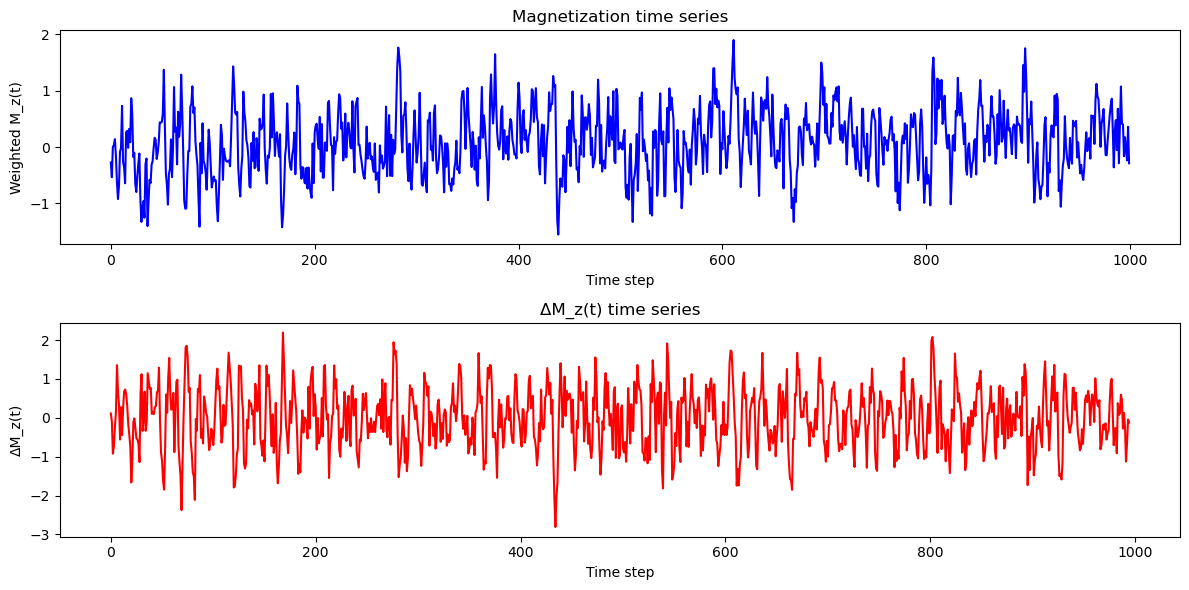

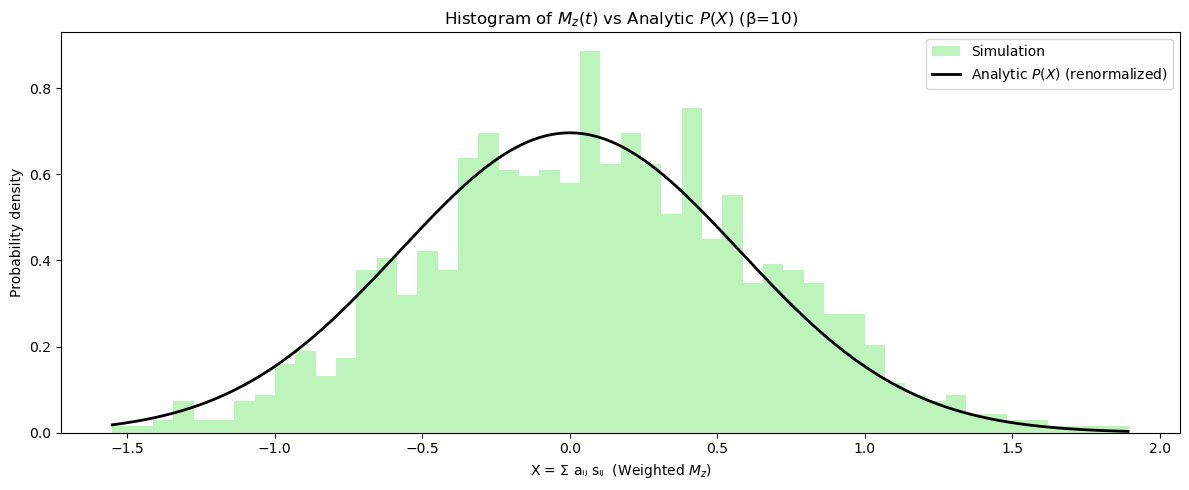

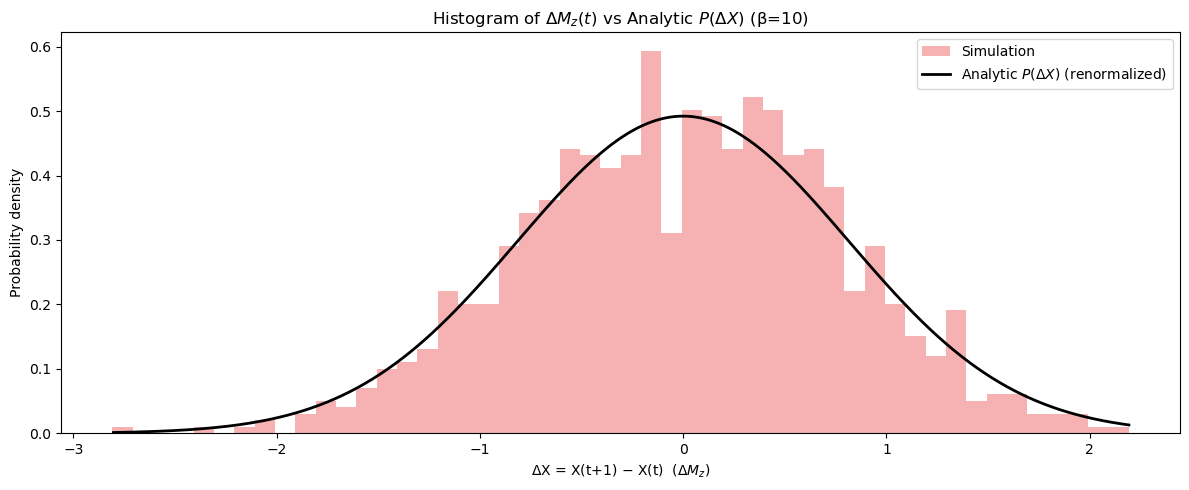

In [370]:
sweeps = 1000
deltat = 5

M, delta_M, a, kurt_M, kurt_delta = run_factorized_model(
    L=L,
    beta=beta,
    alpha=alpha,
    sweeps=sweeps,
    a=a,
    delta_t=deltat
)

print("Kurtosis of M_z(t):", kurt_M)
print("Kurtosis of ΔM_z(t):", kurt_delta)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(M, color='blue')
plt.xlabel('Time step')
plt.ylabel('Weighted M_z(t)')
plt.title('Magnetization time series')

plt.subplot(2,1,2)
plt.plot(delta_M, color='red')
plt.xlabel('Time step')
plt.ylabel('ΔM_z(t)')
plt.title('ΔM_z(t) time series')
plt.tight_layout()
plt.show()

from scipy.interpolate import interp1d

# Compute analytic distributions (exact)
x_analytic, P_x_analytic, m_sc = exact_P_X(a, beta=beta)
dx_analytic, P_dx_analytic, _ = exact_P_deltaX(a, beta=beta)

# --- P(X) histogram vs analytic ---
plt.figure(figsize=(12,5))
counts, bins, _ = plt.hist(M, bins=50, density=True, alpha=0.6, color='lightgreen', label='Simulation')
x_min, x_max = bins[0], bins[-1]

# restrict analytic curve to histogram range
mask_x = (x_analytic >= x_min) & (x_analytic <= x_max)
x_plot = x_analytic[mask_x]
P_plot = P_x_analytic[mask_x]

# renormalize within the interval
norm_factor = np.trapz(P_plot, x_plot)
P_plot /= norm_factor

plt.plot(x_plot, P_plot, 'k-', lw=2, label='Analytic $P(X)$ (renormalized)')
plt.xlabel("X = Σ aᵢⱼ sᵢⱼ  (Weighted $M_z$)")
plt.ylabel("Probability density")
plt.title(f"Histogram of $M_z(t)$ vs Analytic $P(X)$ (β={beta})")
plt.legend()
plt.tight_layout()
plt.show()

# --- P(ΔX) histogram vs analytic ---
plt.figure(figsize=(12,5))
counts_dx, bins_dx, _ = plt.hist(delta_M, bins=50, density=True, alpha=0.6, color='lightcoral', label='Simulation')
dx_min, dx_max = bins_dx[0], bins_dx[-1]

# restrict analytic ΔX curve to histogram range
mask_dx = (dx_analytic >= dx_min) & (dx_analytic <= dx_max)
dx_plot = dx_analytic[mask_dx]
P_dx_plot = P_dx_analytic[mask_dx]

# renormalize within the interval
norm_dx = np.trapz(P_dx_plot, dx_plot)
P_dx_plot /= norm_dx

plt.plot(dx_plot, P_dx_plot, 'k-', lw=2, label='Analytic $P(ΔX)$ (renormalized)')
plt.xlabel("ΔX = X(t+1) − X(t)  (Δ$M_z$)")
plt.ylabel("Probability density")
plt.title(f"Histogram of Δ$M_z(t)$ vs Analytic $P(ΔX)$ (β={beta})")
plt.legend()
plt.tight_layout()
plt.show()

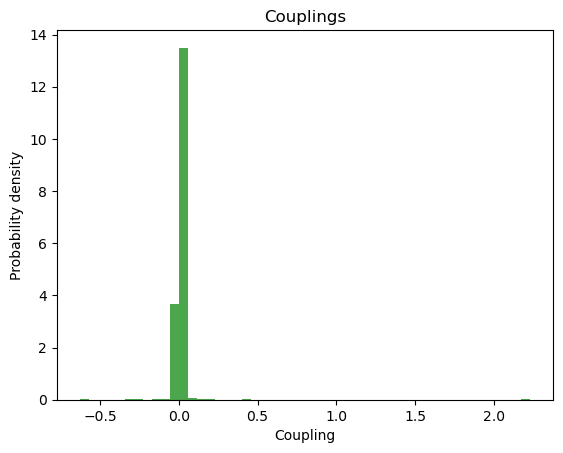

In [391]:
L = 32
beta = 10
alpha = 1 # Heisenberg

a = sample_a_pareto(L, alp=1, xm=1.0, scale='levy')

plt.figure()
plt.hist(a.reshape(L*L) , bins=50, density=True, alpha=0.7, color='green')
plt.xlabel('Coupling')
plt.ylabel('Probability density')
plt.title('Couplings')
plt.show()

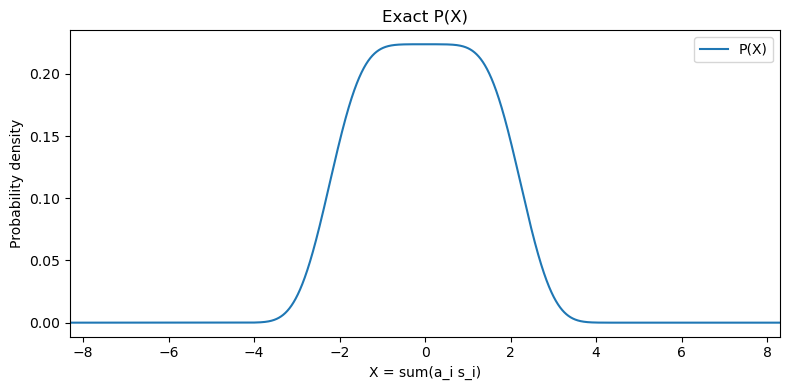

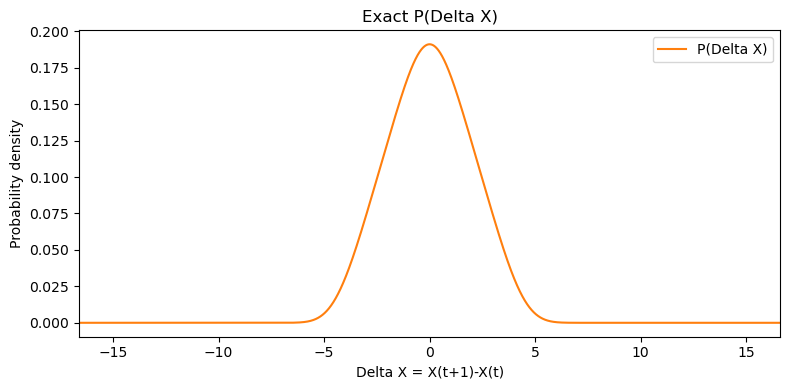

In [392]:
# -------------------------
# Example usage + plotting
# -------------------------
if __name__ == "__main__":
    num_k = 2**13   # reduce if memory / speed issues; increase for higher resolution

    # P(X)
    x, P_x, m_sc_x = exact_P_X(a, beta=beta, num_k=num_k)
    plt.figure(figsize=(8,4))
    plt.plot(x, P_x, label='P(X)')
    plt.xlabel('X = sum(a_i s_i)')
    plt.ylabel('Probability density')
    plt.title('Exact P(X)')
    plt.xlim(-np.sum(np.abs(a))*1.05, np.sum(np.abs(a))*1.05)
    plt.legend()
    plt.tight_layout()

    # P(Delta X)
    dx, P_dx, m_sc_dx = exact_P_deltaX(a, beta=beta, num_k=num_k)
    plt.figure(figsize=(8,4))
    plt.plot(dx, P_dx, label='P(Delta X)', color='C1')
    plt.xlabel('Delta X = X(t+1)-X(t)')
    plt.ylabel('Probability density')
    plt.title('Exact P(Delta X)')
    plt.xlim(-2*np.sum(np.abs(a))*1.05, 2*np.sum(np.abs(a))*1.05)
    plt.legend()
    plt.tight_layout()
    plt.show()



Kurtosis of M_z(t): 2.1183277288236195
Kurtosis of ΔM_z(t): 2.7900289321878122


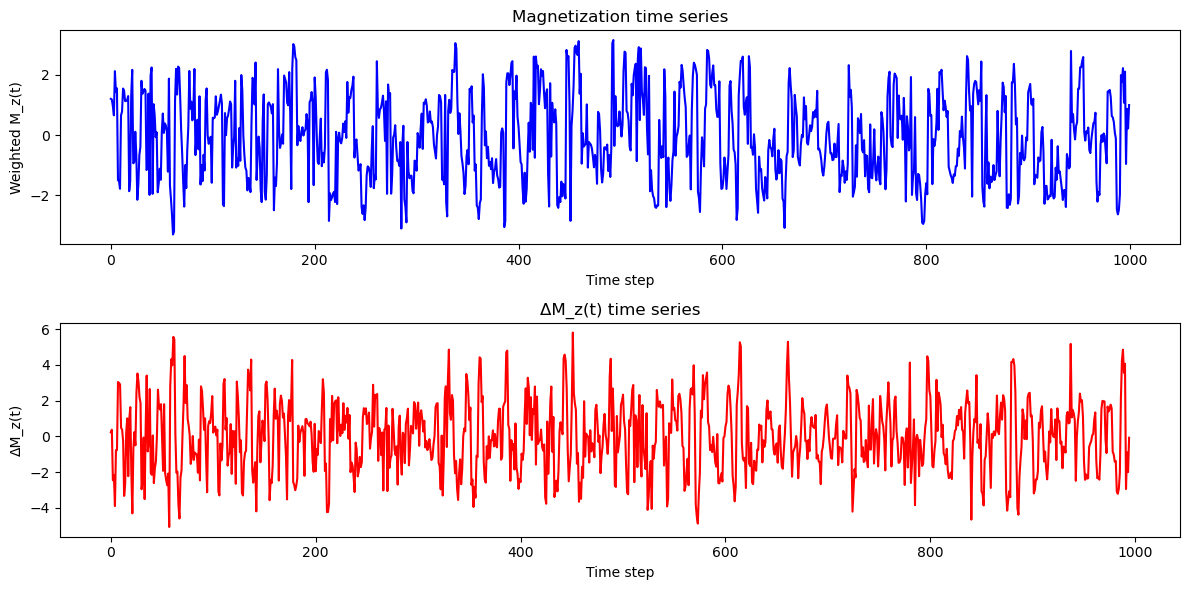

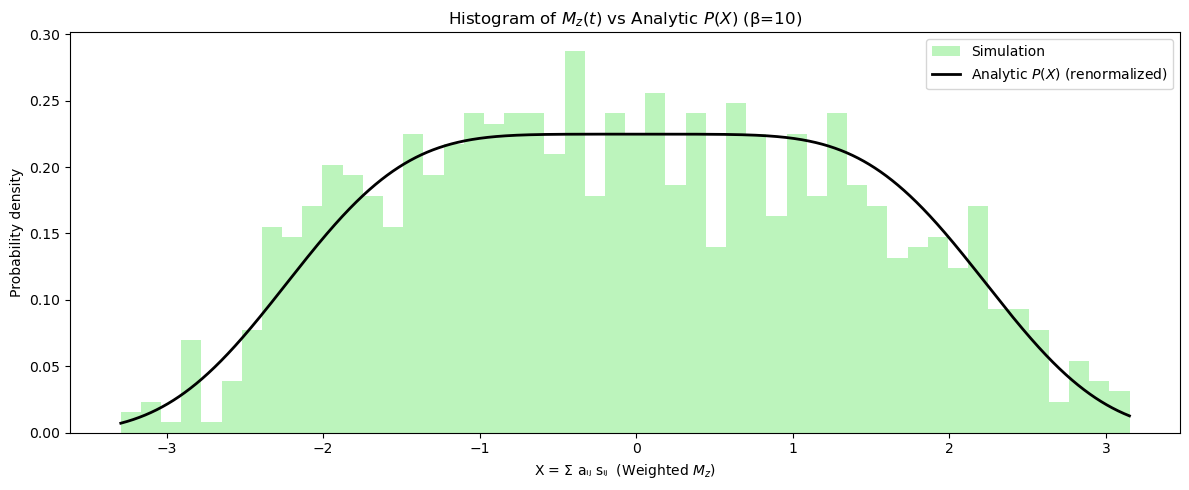

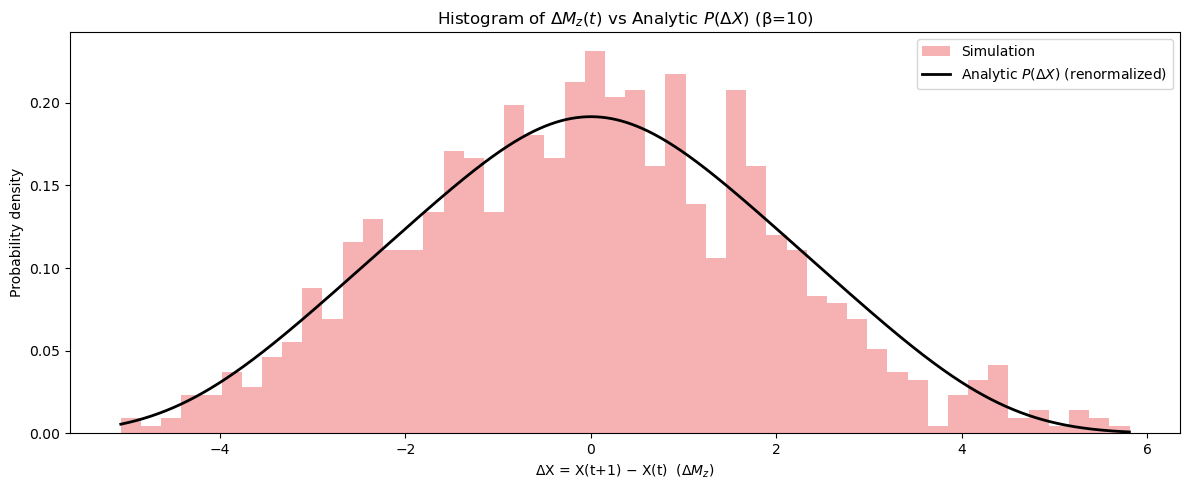

In [393]:
sweeps = 1000
deltat = 5

M, delta_M, a, kurt_M, kurt_delta = run_factorized_model(
    L=L,
    beta=beta,
    alpha=alpha,
    sweeps=sweeps,
    a=a,
    delta_t=deltat
)

print("Kurtosis of M_z(t):", kurt_M)
print("Kurtosis of ΔM_z(t):", kurt_delta)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(M, color='blue')
plt.xlabel('Time step')
plt.ylabel('Weighted M_z(t)')
plt.title('Magnetization time series')

plt.subplot(2,1,2)
plt.plot(delta_M, color='red')
plt.xlabel('Time step')
plt.ylabel('ΔM_z(t)')
plt.title('ΔM_z(t) time series')
plt.tight_layout()
plt.show()

from scipy.interpolate import interp1d

# Compute analytic distributions (exact)
x_analytic, P_x_analytic, m_sc = exact_P_X(a, beta=beta)
dx_analytic, P_dx_analytic, _ = exact_P_deltaX(a, beta=beta)

# --- P(X) histogram vs analytic ---
plt.figure(figsize=(12,5))
counts, bins, _ = plt.hist(M, bins=50, density=True, alpha=0.6, color='lightgreen', label='Simulation')
x_min, x_max = bins[0], bins[-1]

# restrict analytic curve to histogram range
mask_x = (x_analytic >= x_min) & (x_analytic <= x_max)
x_plot = x_analytic[mask_x]
P_plot = P_x_analytic[mask_x]

# renormalize within the interval
norm_factor = np.trapz(P_plot, x_plot)
P_plot /= norm_factor

plt.plot(x_plot, P_plot, 'k-', lw=2, label='Analytic $P(X)$ (renormalized)')
plt.xlabel("X = Σ aᵢⱼ sᵢⱼ  (Weighted $M_z$)")
plt.ylabel("Probability density")
plt.title(f"Histogram of $M_z(t)$ vs Analytic $P(X)$ (β={beta})")
plt.legend()
plt.tight_layout()
plt.show()

# --- P(ΔX) histogram vs analytic ---
plt.figure(figsize=(12,5))
counts_dx, bins_dx, _ = plt.hist(delta_M, bins=50, density=True, alpha=0.6, color='lightcoral', label='Simulation')
dx_min, dx_max = bins_dx[0], bins_dx[-1]

# restrict analytic ΔX curve to histogram range
mask_dx = (dx_analytic >= dx_min) & (dx_analytic <= dx_max)
dx_plot = dx_analytic[mask_dx]
P_dx_plot = P_dx_analytic[mask_dx]

# renormalize within the interval
norm_dx = np.trapz(P_dx_plot, dx_plot)
P_dx_plot /= norm_dx

plt.plot(dx_plot, P_dx_plot, 'k-', lw=2, label='Analytic $P(ΔX)$ (renormalized)')
plt.xlabel("ΔX = X(t+1) − X(t)  (Δ$M_z$)")
plt.ylabel("Probability density")
plt.title(f"Histogram of Δ$M_z(t)$ vs Analytic $P(ΔX)$ (β={beta})")
plt.legend()
plt.tight_layout()
plt.show()

** The distribution for the a_ia_j has heavier tail than Gaussian even when each factor is sampled from a gaussian